In [1]:
import Distributions: Beta, mean, var, mgf, pdf
import ForwardDiff: Dual, derivative
import HypergeometricFunctions: drummond1F1
import Plots
import Polynomials: Polynomial
import QuadGK: quadgk
import Test: @test, @testset
import SpecialFunctions: gamma, lgamma

I've recently been studying [moment-generating functions](https://en.wikipedia.org/wiki/Moment-generating_function) as a pathway to [cumulants](https://en.wikipedia.org/wiki/Cumulant), which I'm interested in because I'm trying to build a deeper understanding of [Edgeworth expansions](https://en.wikipedia.org/wiki/Edgeworth_series). When I tried to call the `mgf` function on a `Beta` distribution object from the [Distributions.jl](https://github.com/JuliaStats/Distributions.jl/) package, I was surprised to see the method wasn't defined.

I set about implementing the missing function, which led me down a deep rabbit hole. This notebook walks through my discoveries in a cleaned up, linearized retelling of how I tried to figure out how to implement `mgf(Beta, t)` correctly. In practice, my real workflow is much more chaotic and has even more mistakes in it.

### Moment-Generating Functions

In general, the moment-generating function (or MGF for short) of a random variable $X$ is defined as:

$$
M_X(t) = \mathbb{E}_{X}[\exp(t X)]
$$

If $X$ is bounded between $a$ and $b$ and has a density function, $f(x)$, then we can write this as:

$$
M_X(t) = \int_{a}^{b} \exp(t x) f(x) dx
$$

### Step 1: Looking Up the Formula

For many popular distributions, there is a well-known analytic formula that does not require evaluating an integral. For example, the MGF of the Bernoulli distribution is:

$$
M(t) = 1 - p + p \exp(t)
$$

Most of the functions in Distributions.jl correspond to well-known formulas like this one, almost all of which can be found on Wikipedia. There's conveniently a little window on the righthand side of the Wikipedia page for the [beta distribution](https://en.wikipedia.org/wiki/Beta_distribution) that contains just such a formula for the beta distribution:

$$
M(t) = 1 + \sum_{k = 1}^{\infty} (\prod_{r = 0}^{k - 1} \frac{\alpha + r}{\alpha + \beta + r}) \frac{t^k}{k!}
$$

This infinite series formula seems simple at first and suggests that we could try approximating $M(t)$ by truncating the infinite series, but we'll soon see that truncating this series is dangerous.

As a quick aside, throughout this document, we're going to almost always simplify things and hold $\alpha$ and $\beta$ fixed to the values so that only need to think of $M(t)$ as a function of $t$ and can ignore how it varies depending on $\alpha$ and $\beta$.

In [2]:
α, β = 2.0, 2.0

(2.0, 2.0)

These parameter values are nice to work with because they let us simplify the density function $f(x)$ to:

$$
f(x) = \frac{x^{\alpha - 1} (1 - x)^{\beta - 1}}{B(\alpha, \beta)} = \frac{x (1 - x)}{B(2, 2)} = \frac{x (1 - x)}{\frac{1}{6}} = 6 (x - x^2)
$$

This means that the MGF is:

$$
M(t) = \int_{0}^{1} \exp(x t) 6 (x - x^2) dx
$$

### First Approach: Naively Implement Infinite Series

In [3]:
function beta_mgf_v0(α::Number, β::Number, t::Number, k_max::Integer = 1_000)
    s = one(t)
    k = 0
    converged = false
    while !converged
        k += 1
        p = one(t)
        for r in 0:(k - 1)
            p *= (α + r) / (α + β + r)
        end
        term = (p / gamma(k + 1)) * t^k
        if s == s + term || k > k_max
            converged = true
        else
            s += term
        end
    end
    s
end

beta_mgf_v0 (generic function with 2 methods)

In [4]:
beta_mgf_v0(α, β, 2.0)

3.0000000000000004

We now immediately confront the main challenge with trying to translate math into code: we often want to write code because the math is very tedious to evaluate by hand. But this means that we often don't know offhand if the answer we have is correct since we haven't previously evaluated it by hand.

In the case of MGF's, we can try to address this problem by enumerating invariants that mathematical reasoning tells us must apply to our function. We can then check whether these invariants apply. In our case, we have the following result, which explains the origin of name, moment-generating function:

* The n-th derivative of M(t) evaluated at 0 equals the n-th non-centered moment of the random variable X.
* In particular, this implies that:
    * $M(0) = 1$
    * $M\prime(0) = \mathbb{E}_{X}[X]$
    * $M\prime\prime(0) = \mathbb{E}_{X}[X^2] = \mathbb{V}_{X}[X] + \mathbb{E}_{X}[X]^2$

Let's test that against our code:

In [5]:
@testset "Derivatives at 0" begin
    for α in 2:2, β in 2:2
        d = Beta(α, β)
        M = t -> beta_mgf_v0(α, β, t)
        M′ = t -> derivative(M, t)
        M′′ = t -> derivative(M′, t)
        @test M′(0.0) ≈ mean(d)
        @test M′′(0.0) ≈ var(d) + mean(d)^2
    end
end

Derivatives at 0: Test Failed at In[5]:7
  Expression: M′(0.0) ≈ mean(d)
   Evaluated: 0.0 ≈ 0.5
Stacktrace:
 [1] top-level scope at In[5]:7
 [2] top-level scope at /Users/johnmyleswhite/julia/usr/share/julia/stdlib/v1.5/Test/src/Test.jl:1114
 [3] top-level scope at In[5]:2
Derivatives at 0: Test Failed at In[5]:8
  Expression: M′′(0.0) ≈ var(d) + mean(d) ^ 2
   Evaluated: 0.0 ≈ 0.3
Stacktrace:
 [1] top-level scope at In[5]:8
 [2] top-level scope at /Users/johnmyleswhite/julia/usr/share/julia/stdlib/v1.5/Test/src/Test.jl:1114
 [3] top-level scope at In[5]:2
Test Summary:    | Fail  Total
Derivatives at 0 |    2      2


Test.TestSetException: Some tests did not pass: 0 passed, 2 failed, 0 errored, 0 broken.

These tests fail, which tells us something is wrong. Unfortunately, it's not immediately obvious what's wrong. In this case, what's wrong is quite subtle and required me to step through the implementation line-by-line while inspecting intermediate variables to discover that the problem is that the infinite series needs to be evaluated to a larger number of terms to compute the derivative at `0.0` than are needed to compute the function itself at `0`. But we won't evaluate the series enough times if we terminate whenever `s == s + term` since that condition only verifies that the function values have stopped changing. Instead, we need to use `s === s + term` to ensure that the derivative has stoppped changing.

If this argument doesn't make sense to you, you can either ignore this or explore the following two topics:

1. Note that ForwardDiff calculates derivatives using dual numbers, which pair the value of a function with a dual variable that is the value of the derivative of the function.
2. ForwardDiff uses `==` to check only the value of the function at the start when the state variable `s` is just a `Float64` number and not yet a dual number.

In [6]:
Dual(1, 0) == Dual(1, 1)

true

In [7]:
Dual(1, 0) === Dual(1, 1)

false

We can easily fix this first bug by replacing `==` with `===`:

In [8]:
function beta_mgf_v1(α::Number, β::Number, t::Number, k_max::Integer = 1_000)
    s = one(t)
    k = 0
    converged = false
    while !converged
        k += 1
        p = one(t)
        for r in 0:(k - 1)
            p *= (α + r) / (α + β + r)
        end
        term = (p / gamma(k + 1)) * t^k
        if s === s + term || k > k_max
            converged = true
        else
            s += term
        end
    end
    s
end

beta_mgf_v1 (generic function with 2 methods)

In [9]:
@testset "Derivatives at 0" begin
    for α in 1:25, β in 1:25
        d = Beta(α, β)
        M = t -> beta_mgf_v1(α, β, t)
        M′ = t -> derivative(M, t)
        M′′ = t -> derivative(M′, t)
        @test M′(0.0) ≈ mean(d)
        @test M′′(0.0) ≈ var(d) + mean(d)^2
    end
end

Test Summary:    | Pass  Total
Derivatives at 0 | 1250   1250


Test.DefaultTestSet("Derivatives at 0", Any[], 1250, false)

At this point, we might be feeling pretty good about ourselves. We've passed a non-trivial test of correctness, which suggests that our approach works reasonably well. We've also tested our code over a non-trivial range (if still extremely small) range of values for $\alpha$ and $\beta$ and gotten correct answers.

Feeling proud of ourselves, we might then decide to plot the MGF over a range of values for $t$ (which is the parameter that we held fixed at `0.0` in our tests) to see what our new function looks like:

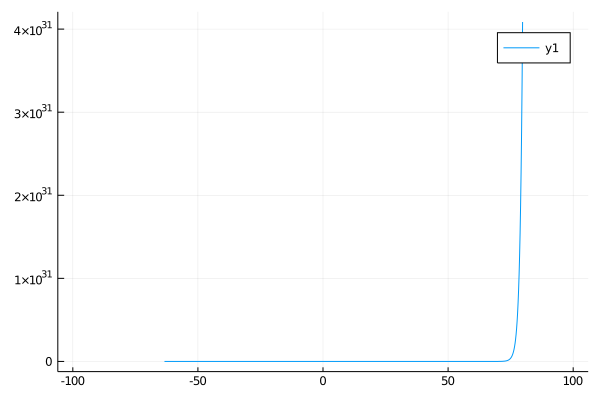

In [10]:
Plots.plot(
    range(-100.0, 100.0, length = 1000),
    t -> beta_mgf_v1(α, β, t),
)

Something seems off here, although it's a bit subtle: what happpened to the values below `-50.0`?

In [11]:
beta_mgf_v1(α, β, -50.0)

81.0113650124519

In [12]:
beta_mgf_v1(α, β, -10.0)

0.04800326879492561

This is a place where intuition comes into play for me: I didn't know for sure that the MGF should be monotonic (although we'll prove it is soon), but it didn't seem possible the the function would start growing for negative values of $t$. So I had to stop, convinve myself the function is monotonic and then conclude that this behavior is a bug.

To see why the MGF must be monotonic, note that $\exp(x)^{t_1} \leq \exp(x)^{t_2}$ whenever $t_1 \leq t_2$ and $0 \leq x$. Then note that the MGF is:

$$
M(t)
= \int_{0}^{1} \exp(x t) \frac{x^{\alpha - 1} (1 - x)^{\beta - 1}}{B(\alpha, \beta)} dx
= \int_{0}^{1} \exp(x)^t \frac{x^{\alpha - 1} (1 - x)^{\beta - 1}}{B(\alpha, \beta)} dx
$$

This implies that:

$$
M(t_1)
= \int_{0}^{1} \exp(x)^{t_1} \frac{x^{\alpha - 1} (1 - x)^{\beta - 1}}{B(\alpha, \beta)} dx
\leq \int_{0}^{1} \exp(x)^{t_2} \frac{x^{\alpha - 1} (1 - x)^{\beta - 1}}{B(\alpha, \beta)} dx
= M(t_2)
$$

So we now have a clear sign of problems: $M(t)$ is provably monotonic, but our implementation is not.

### Performance Optimization

Before we move on to debugging, I want to optimize our implementation at bit. In the naive translation of the math into code, we do a lot of redundant work while calculating each coefficient because:

```
for r in 0:(k - 1)
    p *= (α + r) / (α + β + r)
end
```

differs from its value at `k = k - 1` only by a single term in the product. As such, we'll first optimize this loop and then look for bugs afterwards.

In [13]:
function beta_mgf_v2(α::Number, β::Number, t::Number, k_max::Integer = 1_000)
    s = one(t)
    p = one(t)
    k = 0
    converged = false
    while !converged
        k += 1
        r = k - 1
        p *= (α + r) / (α + β + r)
        term = (p / gamma(k + 1)) * t^k
        if s === s + term || k > k_max
            converged = true
        else
            s += term
        end
    end
    s
end

beta_mgf_v2 (generic function with 2 methods)

In [14]:
beta_mgf_v2(α, β, 2.0)

3.0000000000000004

Before moving on, I want to note that we can go beyond demonstrating that $M(t)$ is monotonic. We can also give non-trivial lower and upper bounds.

Note that:

$$
M(t)
= \int_{0}^{1} \exp(x)^t f(x) dx
$$

If $t > 0$, we know that:

$$
\int_{0}^{1} \exp(0)^t f(x) dx
\leq \int_{0}^{1} \exp(x)^t f(x) dx
\leq \int_{0}^{1} \exp(1)^t f(x) dx
$$

But $\exp(0)^t$ and $\exp(1)^t$ only depend on $t$, so we can pull them out of the integral:

$$
\exp(0)^t \int_{0}^{1} f(x) dx
\leq \int_{0}^{1} \exp(x)^t f(x) dx
\leq \exp(1)^t \int_{0}^{1} f(x) dx
$$

But $f(x)$ is a density, so:

$$
\int_{0}^{1} f(x) dx = 1
$$

This means that we have:

$$
\exp(0)^t
\leq \int_{0}^{1} \exp(x)^t f(x) dx
\leq \exp(1)^t
$$

If $t < 0$, the argument flips around. Together, we get:

$$
1 \leq M(t) \leq e^t: t \geq 0
$$

$$
e^t \leq M(t) \leq 1: t < 0
$$

This gives us a set of mathematical checks we want to pass:

1. $M(0) = 1$
2. $M\prime(0) = \mathbb{E}_{X}[X]$
3. $M\prime\prime(0) = \mathbb{V}_{X} + \mathbb{E}_{X}[X]^2$
4. $M(t_1) \leq M(t_2) : t_1 \leq t_2$
5. $1 \leq M(t) \leq e^t : t \geq 0$
6. $e^t \leq M(t) \leq 1 : t < 0$

### Taking Logs

The first thing I wondered is whether the coefficients were becoming unstable from the iterated product. To test that idea, I implemented the coefficients to work in log space, which isn't clearly helpful since we have to use `exp` to come back out of log sppace, but doing this let me see that the coefficients were not the only thing wrong in the implementation.

In [15]:
function beta_mgf_v3(α::Number, β::Number, t::Number, k_max::Integer = 1_000)
    s = one(t)
    p = zero(t)
    k = 0
    converged = false
    while !converged
        k += 1
        r = k - 1
        p += log(α + r) - log(α + β + r)
        term = exp(p - lgamma(k + 1)) * t^k
        if s === s + term || k > k_max
            converged = true
        else
            s += term
        end
    end
    s
end

beta_mgf_v3 (generic function with 2 methods)

In [16]:
beta_mgf_v3(α, β, -50.0)

-25822.098712402487

This is clearly wrong: we now have a negative number, which violates our lower bound of $e^t$.

In [17]:
exp(-50.0)

1.9287498479639178e-22

Since changing the coefficients change the answer so much, I also tried to deal with the `t^k` term in yet another iteration of log transforming terms:

In [18]:
function beta_mgf_v4(α::Number, β::Number, t::Number, k_max::Integer = 1_000)
    s = one(t)
    p = zero(t)
    k = 0
    converged = false
    while !converged
        k += 1
        r = k - 1
        p += log(α + r) - log(α + β + r)
        term = sign(t)^k * exp(p - lgamma(k + 1) + k * log(abs(t)))
        if s === s + term || k > k_max
            converged = true
        else
            s += term
        end
    end
    s
end

beta_mgf_v4 (generic function with 2 methods)

In [19]:
beta_mgf_v4(α, β, -50.0)

-32029.2467989566

Plotting both suggests there's still a lot wrong:

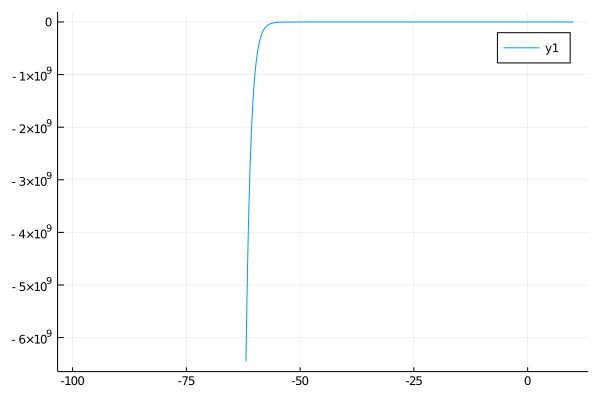

In [20]:
Plots.plot(
    range(-100.0, 10.0, length = 1000),
    t -> beta_mgf_v3(α, β, t),
)

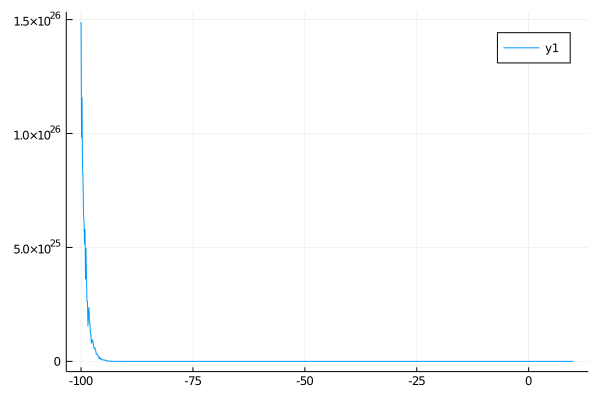

In [21]:
Plots.plot(
    range(-100.0, 10.0, length = 1000),
    t -> beta_mgf_v4(α, β, t),
)

In V3, we're failing the lower bound of $e^t$ check. In V4, we're failing monotonicity.

### Inspecting Partial Sums

At this point, it became clear to me that I needed to evaluate the partial sums for a range of values of `k_max` and see what was happening.

In [22]:
function beta_mgf_v5(α::Number, β::Number, t::Number, k_max::Integer = 1_000)
    s = one(t)
    p = zero(t)
    k = 0
    converged = false
    while !converged
        k += 1
        r = k - 1
        p += log(α + r) - log(α + β + r)
        term = sign(t)^k * exp(p - lgamma(k + 1) + k * log(abs(t)))
        if k > k_max
            converged = true
        else
            s += term
        end
    end
    s
end

beta_mgf_v5 (generic function with 2 methods)

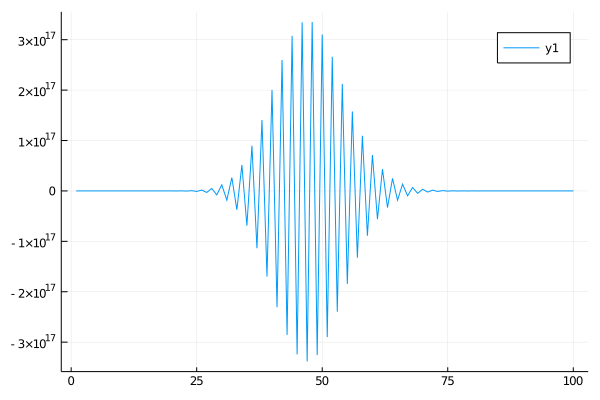

In [23]:
let t = -50.0
    Plots.plot(
        1:100,
        k -> beta_mgf_v5(α, β, t, k),
    )
end

Now this was interesting: almost all of the action in the infinite series was taking place in a subset of the iterations before stabilizing to a value. But the huge amount of values doesn't make clear what value is being stabilized on. So let's check:

In [24]:
beta_mgf_v5(α, β, -50.0, 100)

1.58082497000782e8

That value is huge: the visual stability is an artifact of plotting on a non-logarithmic axis. To address that, let's use the `signed_log` function to visualize the results on a log-like scale:

In [25]:
signed_log(x) = sign(x) * log(1 + abs(x))

signed_log (generic function with 1 method)

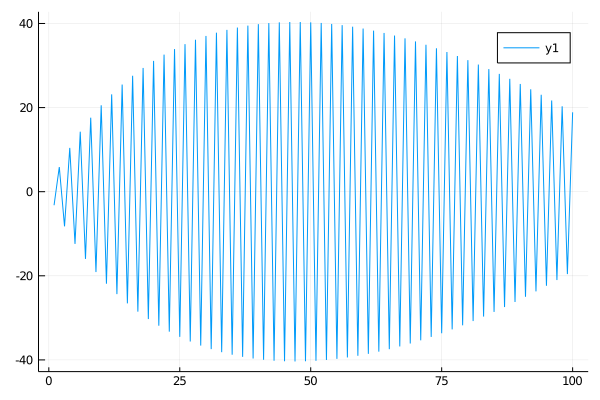

In [26]:
let t = -50.0
    Plots.plot(
        1:100,
        k -> signed_log(beta_mgf_v5(α, β, t, k)),
    )
end

Now it seems like the series is not stabilizing. We might want to evaluate more terms and see what happens:

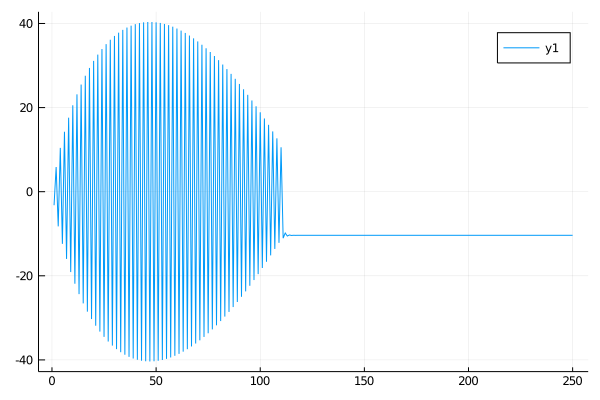

In [27]:
let t = -50.0
    Plots.plot(
        1:250,
        k -> signed_log(beta_mgf_v5(α, β, t, k)),
    )
end

In [28]:
let t = -50.0
    beta_mgf_v5(α, β, t, 250)
end

-32029.2467989566

What's going wrong isn't totally obvious, but it's clear that the alternating series is not stable enough for use.

### Horner's Method

At this point, I tried to look into techniques for improving evaluation of infinite series. One obvious question was whether using Horner's rule would help, so I used the Polynomials.jl package to try that.

In [29]:
function coefs(α, β, k_max)
    c = fill(1.0, 1 + k_max)
    p = 1.0
    for k in 1:k_max
        r = k - 1
        p *= (α + r) / (α + β + r)
        c[k + 1] = p / gamma(k + 1)
    end
    c
end

coefs (generic function with 1 method)

In [30]:
p = Polynomial(coefs(α, β, 250))

Polynomial(1.0 + 0.5*x + 0.15*x^2 + 0.03333333333333333*x^3 + 0.005952380952380952*x^4 + 0.0008928571428571428*x^5 + 0.00011574074074074073*x^6 + 1.3227513227513228e-5*x^7 + 1.352813852813853e-6*x^8 + 1.2526054192720861e-7*x^9 + 1.0598968932302268e-8*x^10 + 8.258936830365404e-10*x^11 + 5.964787710819458e-11*x^12 + 4.014760959205404e-12*x^13 + 2.530311528910969e-13*x^14 + 1.499443868984278e-14*x^15 + 8.385047951556817e-16*x^16 + 4.439143033177139e-17*x^17 + 2.231315281226604e-18*x^18 + 1.067614967094069e-19*x^19 + 4.873894414994662e-21*x^20 + 2.1274935938468763e-22*x^21 + 8.896791392450573e-24*x^22 + 3.5706186190437084e-25*x^23 + 1.377553479569332e-26*x^24 + 5.116627209828948e-28*x^25 + 1.8322139876045305e-29*x^26 + 6.333579216410723e-31*x^27 + 2.1160575723031215e-32*x^28 + 6.8407033587385395e-34*x^29 + 2.142038425463583e-35*x^30 + 6.5033424682006315e-37*x^31 + 1.9161634058091146e-38*x^32 + 5.483969343224738e-40*x^33 + 1.5257466376221448e-41*x^34 + 4.129840522887008e-43*x^35 + 1.0883482859460065e-44*x^36 + 2.794407761212719e-46*x^37 + 6.994987335513224e-48*x^38 + 1.7081776155099448e-49*x^39 + 4.0718187346457987e-51*x^40 + 9.479844060705297e-53*x^41 + 2.1567899185731628e-54*x^42 + 4.797712660122304e-56*x^43 + 1.0439896987693601e-57*x^44 + 2.2233113955273413e-59*x^45 + 4.636008677452752e-61*x^46 + 9.469294319903493e-63*x^47 + 1.8954061342944083e-64*x^48 + 3.7193997925714445e-66*x^49 + 7.158090166835611e-68*x^50 + 1.3515638659239352e-69*x^51 + 2.5046463249639355e-71*x^52 + 4.5569710764168636e-73*x^53 + 8.142735841550601e-75*x^54 + 1.4294457903662496e-76*x^55 + 2.466053572968409e-78*x^56 + 4.1821961178996414e-80*x^57 + 6.974267127079673e-82*x^58 + 1.1439475878206134e-83*x^59 + 1.8460529856364396e-85*x^60 + 2.9317439833365585e-87*x^61 + 4.583123348640277e-89*x^62 + 7.054350512577628e-91*x^63 + 1.0693395133338289e-92*x^64 + 1.5967513095030025e-94*x^65 + 2.3491949437132446e-96*x^66 + 3.4060822211620604e-98*x^67 + 4.867847416325232e-100*x^68 + 6.858883235562927e-102*x^69 + 9.529955180527746e-104*x^70 + 1.3059702569432771e-105*x^71 + 1.765478310312208e-107*x^72 + 2.3548196640790082e-109*x^73 + 3.099534482378477e-111*x^74 + 4.026745652320756e-113*x^75 + 5.164214111070924e-115*x^76 + 6.539102283498896e-117*x^77 + 8.176465343406343e-119*x^78 + 1.0097518176482054e-120*x^79 + 1.2317755606853108e-122*x^80 + 1.484503174253314e-124*x^81 + 1.7677727900003594e-126*x^82 + 2.0803154155229784e-128*x^83 + 2.4196334198064198e-130*x^84 + 2.7819314719699476e-132*x^85 + 3.1621118116198776e-134*x^86 + 3.553842138219019e-136*x^87 + 3.94969967908957e-138*x^88 + 4.341389486053509e-140*x^89 + 4.7200291903329665e-142*x^90 + 5.076486854227647e-144*x^91 + 5.401753746489372e-146*x^92 + 5.687330333445352e-148*x^93 + 5.925601904774165e-150*x^94 + 6.110180267006658e-152*x^95 + 6.236189876890214e-154*x^96 + 6.300480494177741e-156*x^97 + 6.3017535757081864e-158*x^98 + 6.240595737480875e-160*x^99 + 6.11941912121911e-162*x^100 + 5.942314835913453e-164*x^101 + 5.714831261429371e-166*x^102 + 5.443693452909458e-168*x^103 + 5.136482859053677e-170*x^104 + 4.801297910579275e-172*x^105 + 4.446415755859291e-174*x^106 + 4.079973675724753e-176*x^107 + 3.7096857745578755e-178*x^108 + 3.3426067758958573e-180*x^109 + 2.9849505400196315e-182*x^110 + 2.64196665467203e-184*x^111 + 2.3178744718784116e-186*x^112 + 2.015850547712381e-188*x^113 + 1.7380627754305277e-190*x^114 + 1.485742682018727e-192*x^115 + 1.2592863937713057e-194*x^116 + 1.058374604451667e-196*x^117 + 8.821023807938674e-199*x^118 + 7.291106605266848e-201*x^119 + 5.977126688599516e-203*x^120 + 4.8601003466351695e-205*x^121 + 3.919949787777875e-207*x^122 + 3.13636452241874e-209*x^123 + 2.4894943186585126e-211*x^124 + 1.9604767759435788e-213*x^125 + 1.531810942197825e-215*x^126 + 1.187594188984383e-217*x^127 + 9.136429531189493e-220*x^128 + 6.975192853268935e-222*x^129 + 5.284848257826665e-224*x^130 + 3.9740228439849595e-226*x^131 + 2.9660215390011204e-228*x^132 + 2.1972959211972036e-230*x^133 + 1.615834782447012e-232*x^134

In [31]:
p(-50.0)

-97.66989695271194

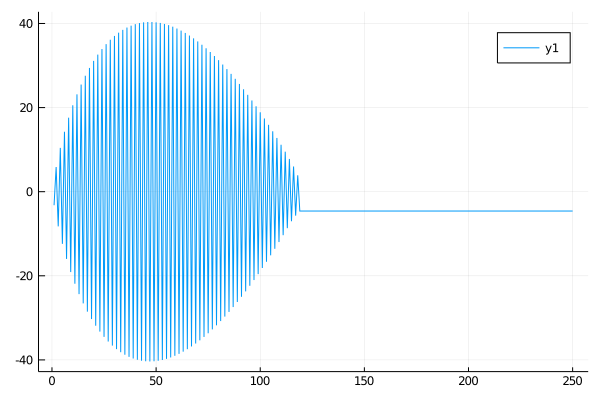

In [32]:
let t = -50.0
    Plots.plot(
        1:250,
        k -> signed_log(Polynomial(coefs(α, β, k))(t))
    )
end

Using Horner's method seems to help, but the end result is still essentially unusable garbage.

To confirm that something's wrong, we can try an alternative implementation by implementing the integral directly.

### Evaluating the MGF Directly as an Expectation via Quadrature

In [33]:
function beta_mgf_v6(α::Number, β::Number, t::Number)
    quadgk(x -> exp(x * t) * pdf(Beta(α, β), x), 0, 1)[1]
end

beta_mgf_v6 (generic function with 1 method)

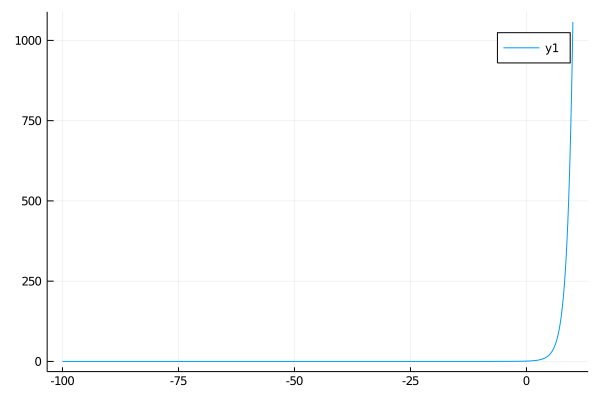

In [34]:
Plots.plot(
    range(-100.0, 10.0, length = 1000),
    t -> beta_mgf_v6(α, β, t),
)

This is **much** better. But I really wanted to find a way to avoid using `quadgk`.

At this point, I went back to searching for alternative formulas for the MGF. I found this [Stack Exchange post](https://math.stackexchange.com/questions/2279885/moment-generating-function-of-beta-distribution), which, in retrospect, seems to be an obvious implication of Wikipedia noting that the characteristic function for the Beta distribution is:

$$
\phi(t) = {}_1 F_1(\alpha; \alpha + \beta; it)
$$

This suggests that:

$$
M(t) = {}_1 F_1(\alpha; \alpha + \beta; t)
$$

In [35]:
function beta_mgf_v7(α::Number, β::Number, t::Number)
    drummond1F1(α, α + β, t)
end

beta_mgf_v7 (generic function with 1 method)

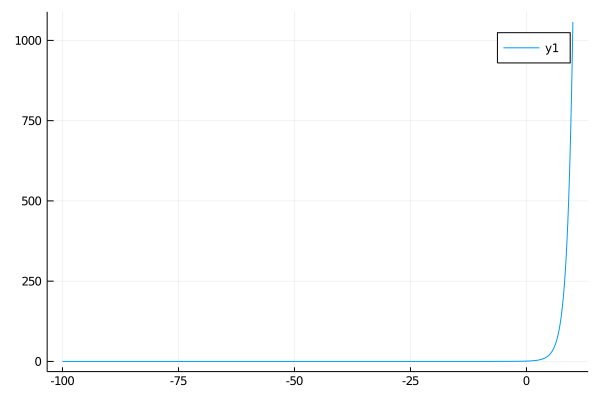

In [36]:
Plots.plot(
    range(-100.0, 10.0, length = 1000),
    t -> beta_mgf_v7(α, β, t),
)

This is much better, although I came to wonder if it was better than my earlier implementation for positive t, so I made a polyalgorithm that combined approaches.

In [37]:
function beta_mgf_v8(α::Number, β::Number, t::Number)
    if t < 0
        drummond1F1(α, α + β, t)
    elseif t < 1
        k_max = 100
        s = one(t)
        p = one(t)
        k = 0
        converged = false
        while !converged
            k += 1
            r = k - 1
            p *= (α + r) / (α + β + r)
            term = (p / gamma(k + 1)) * t^k
            if s === s + term || k > k_max
                converged = true
            else
                s += term
            end
        end
        s
    else
        k_max = 100
        s = one(t)
        p = zero(t)
        k = 0
        converged = false
        while !converged
            k += 1
            r = k - 1
            p += log(α + r) - log(α + β + r)
            term = exp(p - lgamma(k + 1) + k * log(t))
            if s === s + term || k > k_max
                converged = true
            else
                s += term
            end
        end
        s
    end
end

beta_mgf_v8 (generic function with 1 method)

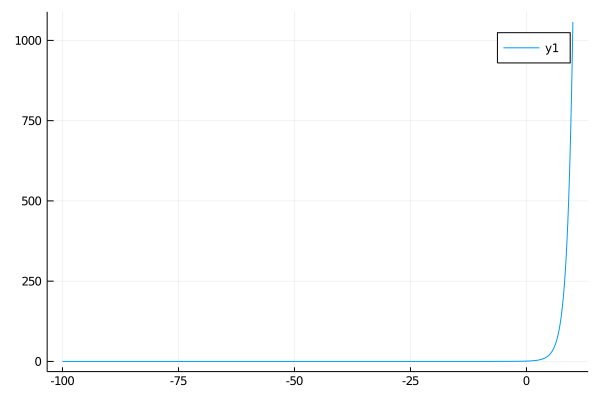

In [38]:
Plots.plot(
    range(-100.0, 10.0, length = 1000),
    t -> beta_mgf_v8(α, β, t),
)

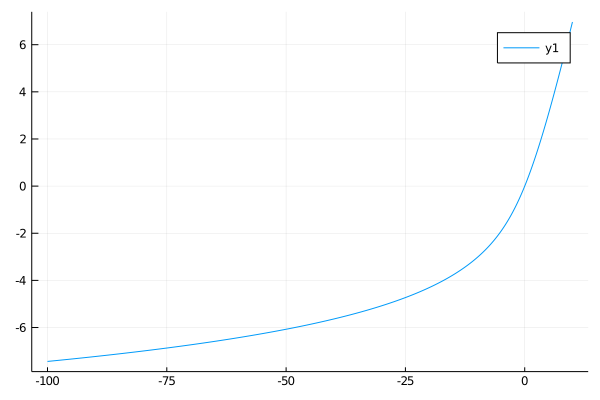

In [39]:
Plots.plot(
    range(-100.0, 10.0, length = 1000),
    t -> log(beta_mgf_v8(α, β, t)),
)

### Testing It All

In [40]:
@testset "Derivatives at 0" begin
    for α in 1:25, β in 1:25
        M = t -> beta_mgf_v8(α, β, t)
        M′ = t -> derivative(M, t)
        M′′ = t -> derivative(M′, t)
        d = Beta(α, β)
        @test M(0.0) ≈ 1.0
        @test M′(0.0) ≈ mean(d)
        @test M′′(0.0) ≈ var(d) + mean(d)^2
    end
end

Test Summary:    | Pass  Total
Derivatives at 0 | 1875   1875


Test.DefaultTestSet("Derivatives at 0", Any[], 1875, false)

In [41]:
@testset "Lower and upper bounds" begin
    r = range(-100.0, 10.0, length = 1000)
    for t in r
        if t <= 0
            @test exp(t) <= beta_mgf_v8(α, β, t) <= 1.0
        else
            @test 1.0 <= beta_mgf_v8(α, β, t) <= exp(t)
        end
    end
end

Test Summary:          | Pass  Total
Lower and upper bounds | 1000   1000


Test.DefaultTestSet("Lower and upper bounds", Any[], 1000, false)

In [42]:
@testset "Monotonicity" begin
    r = range(-100.0, 10.0, length = 1000)
    t_previous = -Inf
    for (i, t) in enumerate(r)
        if i == 1
            t_previous = t
        else
            @test beta_mgf_v8(α, β, t_previous) < beta_mgf_v8(α, β, t)
            t_previous = t
        end
    end
end

Test Summary: | Pass  Total
Monotonicity  |  999    999


Test.DefaultTestSet("Monotonicity", Any[], 999, false)

In [43]:
@testset "Numerical Accuracy" begin
    r = range(-100.0, 10.0, length = 1000)
    for t in r
        @test beta_mgf_v8(α, β, t) ≈ Float64(beta_mgf_v8(α, β, big(t)))
    end
end

Test Summary:      | Pass  Total
Numerical Accuracy | 1000   1000


Test.DefaultTestSet("Numerical Accuracy", Any[], 1000, false)